In [53]:
import pandas as pd
import numpy as np

# Modeling libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score

# Missing value handling
from sklearn.impute import SimpleImputer

# Pipelines and preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

# SHAP for model interpretation
import shap

# Display settings
pd.set_option('display.max_columns', None)


In [60]:
# Target variable
y = df_claims['TotalClaims']

# Drop columns not needed or highly correlated with target
cols_to_drop = [
    'TotalClaims', 'HasClaim', 'ClaimFrequency', 'ClaimSeverity', 
    'Margin', 'TotalPremium', 'CalculatedPremiumPerTerm', 
    'PolicyID', 'UnderwrittenCoverID'
]

X = df_claims.drop(columns=[col for col in cols_to_drop if col in df_claims.columns])
print(f"Feature columns: {X.columns.tolist()}")

# Identify numeric and categorical columns
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()


Feature columns: ['TransactionMonth', 'IsVATRegistered', 'Citizenship', 'LegalType', 'Title', 'Language', 'Bank', 'AccountType', 'MaritalStatus', 'Gender', 'Country', 'Province', 'PostalCode', 'MainCrestaZone', 'SubCrestaZone', 'ItemType', 'mmcode', 'VehicleType', 'RegistrationYear', 'make', 'Model', 'Cylinders', 'cubiccapacity', 'kilowatts', 'bodytype', 'NumberOfDoors', 'VehicleIntroDate', 'CustomValueEstimate', 'AlarmImmobiliser', 'TrackingDevice', 'CapitalOutstanding', 'NewVehicle', 'WrittenOff', 'Rebuilt', 'Converted', 'CrossBorder', 'NumberOfVehiclesInFleet', 'SumInsured', 'TermFrequency', 'ExcessSelected', 'CoverCategory', 'CoverType', 'CoverGroup', 'Section', 'Product', 'StatutoryClass', 'StatutoryRiskType']


In [62]:
# --- Numeric columns ---
# Convert numeric columns to numeric (coerce errors)
for col in numeric_cols:
    X[col] = pd.to_numeric(X[col], errors='coerce')

# Keep only numeric columns with at least one non-NaN value
numeric_cols_fixed = [col for col in numeric_cols if X[col].notna().sum() > 0]

# Impute missing numeric values with median
imputer_num = SimpleImputer(strategy='median')
X_numeric_imputed = imputer_num.fit_transform(X[numeric_cols_fixed])

# Replace only the valid numeric columns
X[numeric_cols_fixed] = pd.DataFrame(
    X_numeric_imputed,
    columns=numeric_cols_fixed,
    index=X.index
)

# --- Categorical columns ---
# Convert all categorical columns to string
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
for col in categorical_cols:
    X[col] = X[col].astype(str)

print("Data types and missing values fixed.")


Data types and missing values fixed.


In [63]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")


Train shape: (2230, 47), Test shape: (558, 47)


In [64]:
# Preprocessor: numeric -> median impute, categorical -> one-hot
preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), numeric_cols),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
            ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))
        ]), categorical_cols)
    ]
)


In [65]:
# --- Linear Regression ---
lr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])
lr_pipeline.fit(X_train, y_train)
y_pred_lr = lr_pipeline.predict(X_test)

# --- Random Forest ---
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])
rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)

# --- XGBoost ---
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42))
])
xgb_pipeline.fit(X_train, y_train)
y_pred_xgb = xgb_pipeline.predict(X_test)


In [67]:
def evaluate_model(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} -> RMSE: {rmse:.2f}, R2: {r2:.4f}")
    return rmse, r2

rmse_lr, r2_lr = evaluate_model(y_test, y_pred_lr, "Linear Regression")
rmse_rf, r2_rf = evaluate_model(y_test, y_pred_rf, "Random Forest")
rmse_xgb, r2_xgb = evaluate_model(y_test, y_pred_xgb, "XGBoost")


Linear Regression -> RMSE: 38846.62, R2: 0.0617
Random Forest -> RMSE: 36505.72, R2: 0.1714
XGBoost -> RMSE: 38548.17, R2: 0.0760


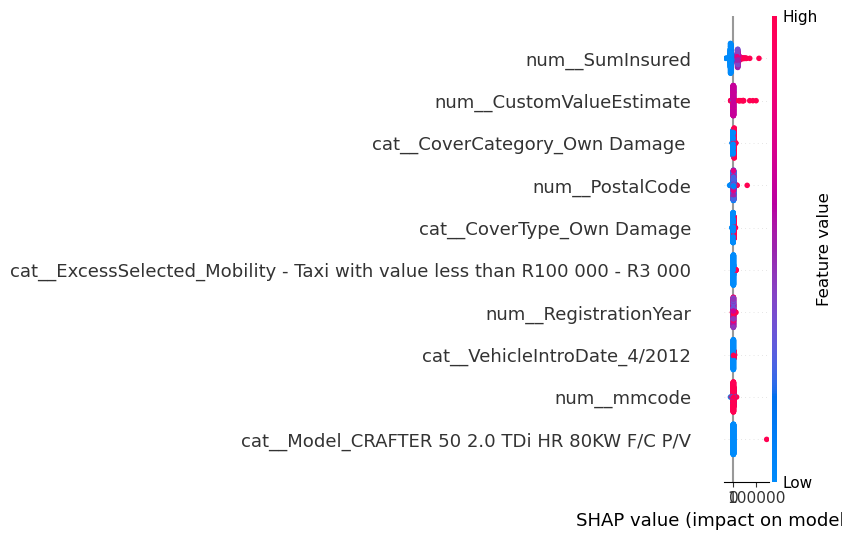

In [70]:
# Use the preprocessor to transform X_train/X_test
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Convert sparse matrices to dense arrays for SHAP
X_train_dense = X_train_processed.toarray() if hasattr(X_train_processed, "toarray") else X_train_processed
X_test_dense = X_test_processed.toarray() if hasattr(X_test_processed, "toarray") else X_test_processed

# Train XGBoost model separately for SHAP
xgb_model_shap = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
xgb_model_shap.fit(X_train_dense, y_train)

# Get feature names from preprocessor
try:
    feature_names = preprocessor.get_feature_names_out()
except:
    feature_names = None

# SHAP explainer
explainer = shap.Explainer(xgb_model_shap, X_train_dense)
shap_values = explainer(X_test_dense)

# Summary plot (top 10 features)
shap.summary_plot(shap_values, features=X_test_dense, feature_names=feature_names, max_display=10)
